Physics-Informed Neural Network for 2D Heat Equation

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# Neural Network Architecture for PINN
class Heat2DPINN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=50, hidden_layers=3, output_dim=1):
        super(Heat2DPINN, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, input_tensor):
        return self.model(input_tensor)

# Initial temperature distribution at t = 0
def initial_temperature(x, y):
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

# Constant Dirichlet boundary condition (e.g., T=0)
def fixed_boundary(x, y, t, value=0.0):
    return torch.full_like(x, value)

In [44]:
# Generate space-time interior points
def sample_collocation_points(n_points):
    x = torch.rand(n_points, 1, requires_grad=True)
    y = torch.rand(n_points, 1, requires_grad=True)
    t = torch.rand(n_points, 1, requires_grad=True)
    return x, y, t

# Generate spatial boundary coordinates
def sample_boundary_points(n_points):
    x_vals = torch.tensor([0.0, 1.0]).repeat(n_points // 2)
    y_vals = torch.rand(n_points)
    if torch.rand(1).item() > 0.5:
        x_vals, y_vals = y_vals, x_vals
    return x_vals.view(-1, 1), y_vals.view(-1, 1)

# Combine with time
def generate_boundary_data(n_points):
    xb, yb = sample_boundary_points(n_points)
    tb = torch.rand(n_points, 1, requires_grad=True)
    return xb, yb, tb

In [45]:
# PDE loss using autograd
def compute_physics_loss(model, x, y, t):
    input_tensor = torch.cat([x, y, t], dim=1)
    u = model(input_tensor)

    du_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    du_xx = torch.autograd.grad(du_x, x, grad_outputs=torch.ones_like(du_x), create_graph=True)[0]
    du_yy = torch.autograd.grad(du_y, y, grad_outputs=torch.ones_like(du_y), create_graph=True)[0]

    residual = du_t - (du_xx + du_yy)
    return torch.mean(residual**2)

In [46]:
def train(model, epochs=5000, lr=1e-3, n_interior=1000, n_boundary=200):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []

    for epoch in range(epochs):
        model.train()

        # Sample training data
        x_int, y_int, t_int = sample_collocation_points(n_interior)
        x_bnd, y_bnd, t_bnd = generate_boundary_data(n_boundary)
        x_ini = torch.rand(n_boundary, 1, requires_grad=True)
        y_ini = torch.rand(n_boundary, 1, requires_grad=True)
        t_ini = torch.zeros_like(x_ini, requires_grad=True)

        # Initial condition loss
        input_ini = torch.cat([x_ini, y_ini, t_ini], dim=1)
        pred_ini = model(input_ini)
        true_ini = initial_temperature(x_ini, y_ini)
        loss_ini = torch.mean((pred_ini - true_ini) ** 2)

        # Boundary condition loss
        input_bnd = torch.cat([x_bnd, y_bnd, t_bnd], dim=1)
        pred_bnd = model(input_bnd)
        true_bnd = fixed_boundary(x_bnd, y_bnd, t_bnd)
        loss_bnd = torch.mean((pred_bnd - true_bnd) ** 2)

        # PDE residual loss
        loss_phys = compute_physics_loss(model, x_int, y_int, t_int)

        total_loss = loss_ini + loss_bnd + loss_phys

        loss_history.append(total_loss.item())
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"[Epoch {epoch}] Total Loss: {total_loss.item():.6f} | PDE Loss: {loss_phys.item():.6f}")

    return loss_history

In [47]:
def plot_solution(model, t_fixed=0.01, resolution=100):
    x_vals = torch.linspace(0, 1, resolution)
    y_vals = torch.linspace(0, 1, resolution)
    X, Y = torch.meshgrid(x_vals, y_vals, indexing="ij")
    T = torch.full_like(X, t_fixed)

    input_grid = torch.cat([X.reshape(-1,1), Y.reshape(-1,1), T.reshape(-1,1)], dim=1)
    with torch.no_grad():
        prediction = model(input_grid).reshape(resolution, resolution)

    plt.figure(figsize=(8,6))
    sns.heatmap(prediction.numpy(), xticklabels=False, yticklabels=False, cmap="jet")
    plt.title(f"2D Heat Equation Solution at t = {t_fixed}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

[Epoch 0] Total Loss: 0.362500 | PDE Loss: 0.000276
[Epoch 500] Total Loss: 0.000830 | PDE Loss: 0.000309
[Epoch 1000] Total Loss: 0.000389 | PDE Loss: 0.000070
[Epoch 1500] Total Loss: 0.000483 | PDE Loss: 0.000053
[Epoch 2000] Total Loss: 0.000104 | PDE Loss: 0.000030
[Epoch 2500] Total Loss: 0.000159 | PDE Loss: 0.000029
[Epoch 3000] Total Loss: 0.000081 | PDE Loss: 0.000018
[Epoch 3500] Total Loss: 0.000317 | PDE Loss: 0.000021
[Epoch 4000] Total Loss: 0.000070 | PDE Loss: 0.000028
[Epoch 4500] Total Loss: 0.000057 | PDE Loss: 0.000010


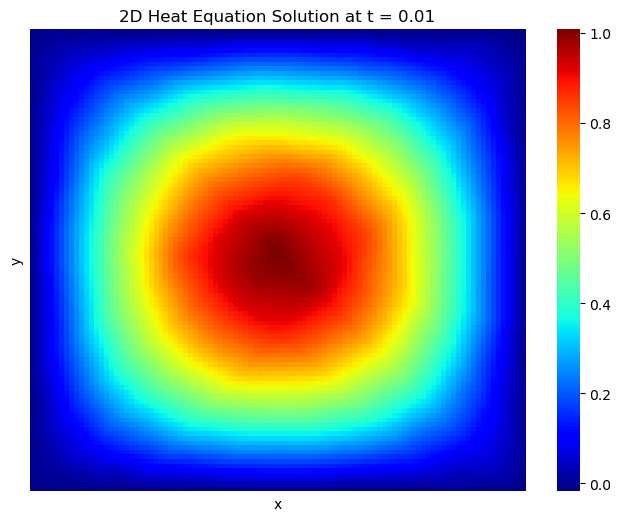

In [48]:
model = Heat2DPINN()
train(model)

plot_solution(model, t_fixed=0.01)

FDM solution

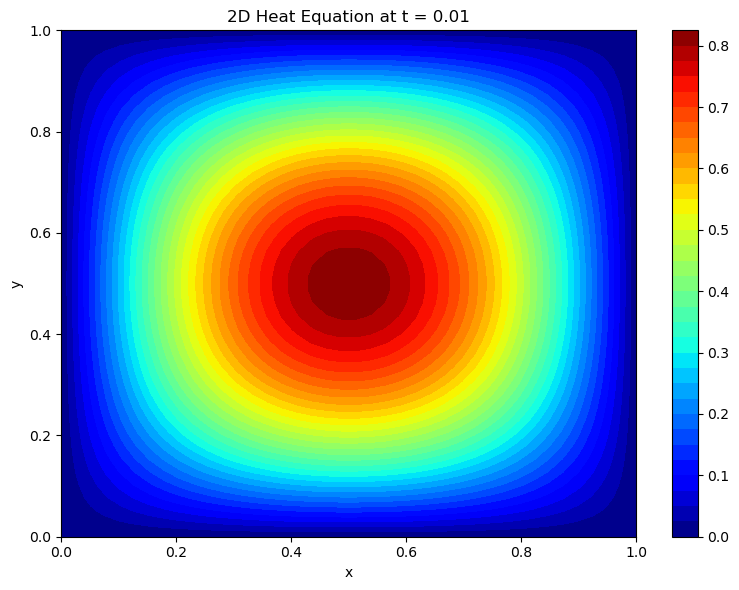

In [49]:
import numpy as np
from scipy.linalg import solve_banded

Lx, Ly = 1.0, 1.0
Nx, Ny = 39, 39
dx, dy = Lx / Nx, Ly / Ny
dt = 0.0005
alpha = 1.0
T = 0.01
Nt = int(T / dt)

x = np.linspace(0, Lx, Nx+1)
y = np.linspace(0, Ly, Ny+1)
X, Y = np.meshgrid(x, y, indexing='ij')

# Initial condition
u = np.sin(np.pi * X) * np.sin(np.pi * Y)
solution_array = np.zeros((Nx+1, Ny+1, Nt+1))
solution_array[:, :, 0] = u.copy()

# Coefficients for ADI
rx = alpha * dt / (2 * dx**2)
ry = alpha * dt / (2 * dy**2)

# Tridiagonal matrices for x- and y-sweeps
def create_tridiagonal(N, r):
    ab = np.zeros((3, N-1))
    ab[0, 1:] = -r  
    ab[1, :] = 1 + 2*r  
    ab[2, :-1] = -r  
    return ab

A_x = create_tridiagonal(Nx, rx)
A_y = create_tridiagonal(Ny, ry)

# Time stepping using ADI method
for n in range(1, Nt+1):
    u_half = np.zeros_like(u)
    for j in range(1, Ny):  # for each y
        rhs = ry * u[1:-1, j-1] + (1 - 2*ry) * u[1:-1, j] + ry * u[1:-1, j+1]
        u_half[1:-1, j] = solve_banded((1, 1), A_x, rhs)

    u_new = np.zeros_like(u)
    for i in range(1, Nx):  # for each x
        rhs = rx * u_half[i-1, 1:-1] + (1 - 2*rx) * u_half[i, 1:-1] + rx * u_half[i+1, 1:-1]
        u_new[i, 1:-1] = solve_banded((1, 1), A_y, rhs)

    u = u_new.copy()
    solution_array[:, :, n] = u.copy()

plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, u, 39, cmap='jet')
plt.colorbar(cp)
plt.title(f"2D Heat Equation at t = {T}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

In [50]:
## Comparison
def generate_eval_grid(N=40, t_val=0.01):
    x_vals = torch.linspace(0, 1, N)
    y_vals = torch.linspace(0, 1, N)
    X, Y = torch.meshgrid(x_vals, y_vals, indexing="ij")
    T = torch.full_like(X, t_val)
    return X, Y, T

def evaluate_pinn(model, X, Y, T):
    input_tensor = torch.cat([X.reshape(-1,1), Y.reshape(-1,1), T.reshape(-1,1)], dim=1)
    with torch.no_grad():
        pred = model(input_tensor).reshape(X.shape)
    return pred

def analytical_solution(X, Y, T):
    return torch.sin(torch.pi * X) * torch.sin(torch.pi * Y) * torch.exp(-2 * torch.pi**2 * T)

def extract_fdm_slice(fdm_array, t_idx):
    return torch.tensor(fdm_array[:, :, t_idx], dtype=torch.float32)


def compare_all(model, fdm_array, dt, t_val=0.01, N=101):
    import matplotlib.ticker as ticker

    t_idx = int(t_val / dt)
    # Create uniform grid
    X, Y, T = generate_eval_grid(N, t_val)
    u_pinn = evaluate_pinn(model, X, Y, T)
    u_exact = analytical_solution(X, Y, T)
    u_fdm = extract_fdm_slice(fdm_array, t_idx)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    titles = ['PINN Solution', 'Analytical Solution', 'FDM Solution']
    data = [u_pinn, u_exact, u_fdm]

    for ax, z, title in zip(axes, data, titles):
        im = ax.imshow(z.numpy(), origin='lower', cmap='jet', extent=[0, 1, 0, 1])
        ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046)

    plt.tight_layout()
    plt.show()

    mse_pinn_analytical = torch.mean((u_pinn - u_exact) ** 2).item()
    mse_pinn_fdm = torch.mean((u_pinn - u_fdm) ** 2).item()
    mse_fdm_analytical = torch.mean((u_fdm - u_exact) ** 2).item()

    print(f"MSE (PINN vs Analytical): {mse_pinn_analytical:.6e}")
    print(f"MSE (PINN vs FDM):        {mse_pinn_fdm:.6e}")
    print(f"MSE (FDM vs Analytical):  {mse_fdm_analytical:.6e}")

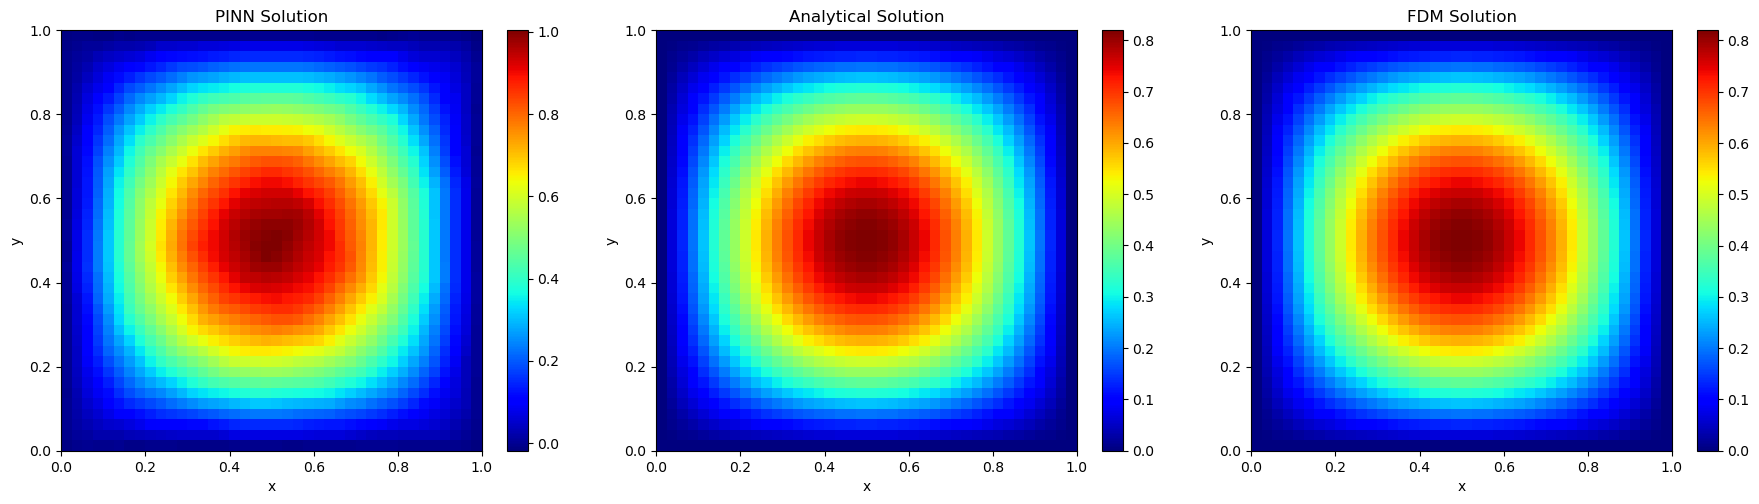

MSE (PINN vs Analytical): 7.068230e-03
MSE (PINN vs FDM):        7.061097e-03
MSE (FDM vs Analytical):  1.810575e-09


In [51]:
compare_all(model, solution_array, dt=0.0005, t_val=0.01, N=40)